# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

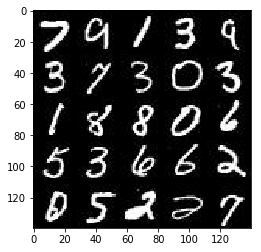

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

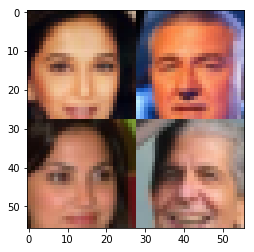

In [16]:
show_n_images = 4

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [37]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    l_rate = tf.placeholder(tf.float32,name="l_rate")
    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [40]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.1):
    stddev = 0.02

    lrelu = lambda x: tf.maximum(alpha*x, x)
    def conv(x, d, bn=True):
        x = tf.layers.conv2d(x, d, 5,
                             strides=2,
                             padding="same",
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        if bn:
            x = tf.layers.batch_normalization(x, training=True)
            return lrelu(x)
        else:
            return lrelu(x)

    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28xC
        x = conv(images, 64) # 14x14x64
        x = conv(x, 128)     # 7x7x128
        x = conv(x, 256)     # 4x4x256
        x = conv(x, 512)     # 2x2x512

        # Flatten it
        logits = tf.layers.dense(
            tf.reshape(x, (-1, np.prod(x.get_shape().as_list()[1:]))), 1,kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        logits = tf.nn.dropout(logits, 0.5)
        out = tf.sigmoid(logits)

        return out, logits    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim,is_train=True,alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    stddev = 0.02

    lrelu = lambda x: tf.maximum(alpha*x, x)
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='valid',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))

        out = tf.tanh(logits)
       
    return out 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7,1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*np.random.uniform(0.7,1.2)))

    d_loss = d_loss_real + d_loss_fake
    print("asda")
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

asda
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,print_every=100, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    # Create our input placeholders
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
          
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    losses = []
    
    with tf.Session() as sess:        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                
#                 batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
#                 batch_images = batch_images*2 - 1
                # Sample random noise for G
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
#                 batch_z = batch_z.reshape(batch_size, z_dim)               
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,l_rate:learning_rate})
                
                # show output every 100 batches
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if i % 10 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                    # Sample from generator as we're training for viewing afterwards
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_real: batch_images, input_z: sample_z,l_rate:learning_rate})
                    samples.append(gen_samples)
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

asda
Epoch 1/2... Discriminator Loss: 1.5479... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 2.0036... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 2.0998
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 1.4910
Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 1.8020
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 2.0867... Generator Loss: 0.5510


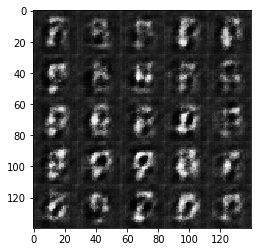

Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.5726
Epoch 1/2... Discriminator Loss: 1.7567... Generator Loss: 1.7763
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7539
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5339


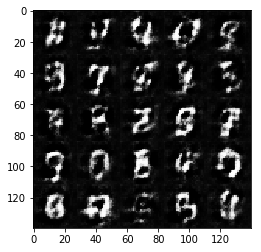

Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 1.5520... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.8240... Generator Loss: 0.5665


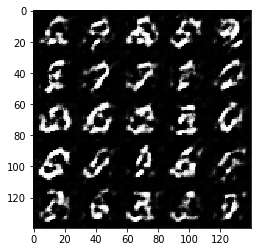

Epoch 1/2... Discriminator Loss: 1.0101... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 0.5576
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.5733
Epoch 1/2... Discriminator Loss: 1.6079... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.7634... Generator Loss: 0.5466


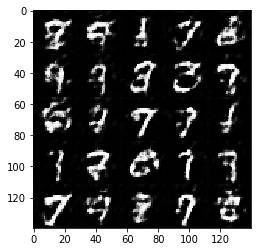

Epoch 1/2... Discriminator Loss: 1.6032... Generator Loss: 0.5016
Epoch 1/2... Discriminator Loss: 1.5982... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 1.8806... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.6220


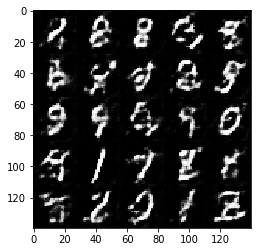

Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.8013... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.5779


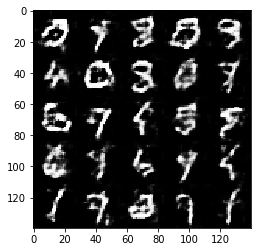

Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.5959... Generator Loss: 0.5537
Epoch 1/2... Discriminator Loss: 1.6390... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.7807... Generator Loss: 0.5870


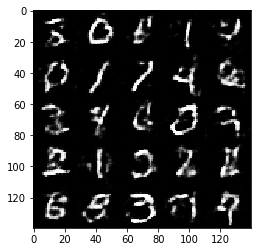

Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 1.0442
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.8756... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.7832


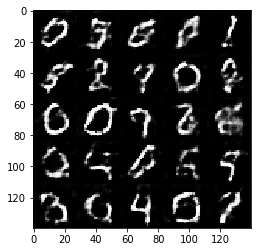

Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.8554... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.8637... Generator Loss: 0.5451
Epoch 1/2... Discriminator Loss: 1.5836... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.7743... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 1.6445... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.5443


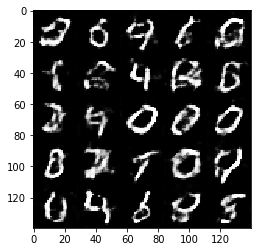

Epoch 1/2... Discriminator Loss: 1.6859... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.4746... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.5640... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 2.0454... Generator Loss: 0.6005


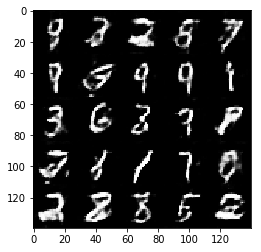

Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.5398
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.7621... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.5970


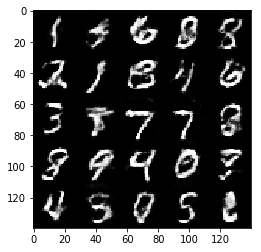

Epoch 1/2... Discriminator Loss: 1.6220... Generator Loss: 0.5062
Epoch 1/2... Discriminator Loss: 1.7587... Generator Loss: 0.5151
Epoch 1/2... Discriminator Loss: 1.7692... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 1.5719... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.5763
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 1.6158... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 1.5900... Generator Loss: 0.5955


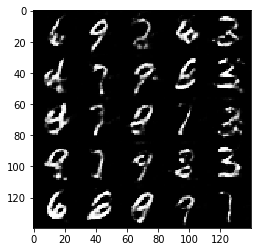

Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.5634... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 2.0459... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.7469... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 2.2484... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 2.1619... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.9685... Generator Loss: 0.5559


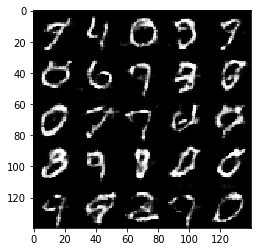

Epoch 1/2... Discriminator Loss: 1.9621... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 2.0286... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.6771
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.5245
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.5782
Epoch 1/2... Discriminator Loss: 1.5499... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.5319


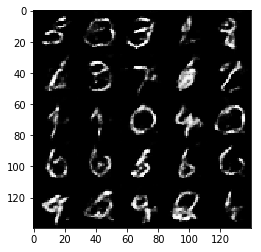

Epoch 1/2... Discriminator Loss: 1.8175... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 1.4888... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 1.8759... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 1.7681... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.7294... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 2.0729... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.5581


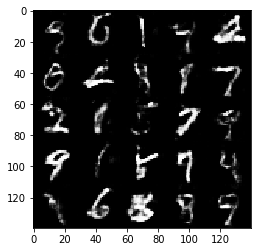

Epoch 1/2... Discriminator Loss: 2.0796... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.7809... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.5342
Epoch 1/2... Discriminator Loss: 2.5894... Generator Loss: 2.0905
Epoch 1/2... Discriminator Loss: 2.1109... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 2.0329... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 1.0188


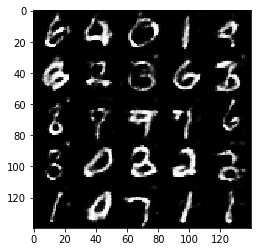

Epoch 1/2... Discriminator Loss: 1.7323... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.8230... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.6898... Generator Loss: 0.5656
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 1.6360... Generator Loss: 0.5670
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.5666
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.5670
Epoch 1/2... Discriminator Loss: 2.3485... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 2.0626... Generator Loss: 0.5161


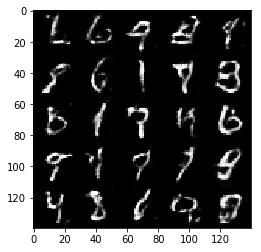

Epoch 1/2... Discriminator Loss: 1.6333... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.5220... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 2.0340... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.8532... Generator Loss: 0.6306
Epoch 1/2... Discriminator Loss: 1.9626... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.6211


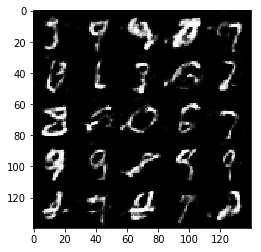

Epoch 1/2... Discriminator Loss: 1.8811... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.7722... Generator Loss: 0.6072
Epoch 1/2... Discriminator Loss: 1.7999... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.5728
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 1.6038... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 1.8050... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 2.4437... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 1.7315... Generator Loss: 0.5581
Epoch 2/2... Discriminator Loss: 1.9282... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 1.5970... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 1.7018... Generator Loss: 0.5523
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 0.7594
Epoch 2/2.

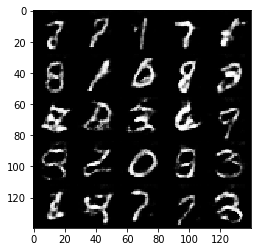

Epoch 2/2... Discriminator Loss: 2.1097... Generator Loss: 0.5739
Epoch 2/2... Discriminator Loss: 2.1206... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.8505... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 1.6118... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.5839
Epoch 2/2... Discriminator Loss: 1.8295... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.5257
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.4675... Generator Loss: 0.5898


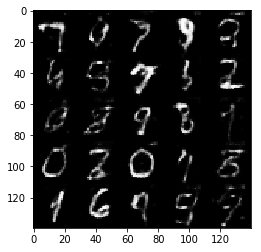

Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.5741
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 2.2793... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.5898
Epoch 2/2... Discriminator Loss: 2.1094... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.8241... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 2.3682... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 2.5245... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 1.5272... Generator Loss: 0.5686


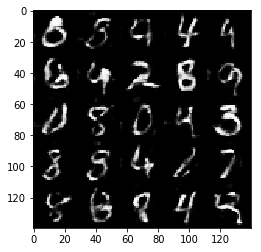

Epoch 2/2... Discriminator Loss: 1.9440... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 2.3488... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 2.2489... Generator Loss: 0.5942
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.7348
Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 2.5722... Generator Loss: 0.5587
Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 0.6377


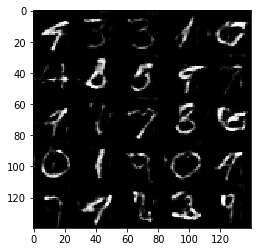

Epoch 2/2... Discriminator Loss: 1.5019... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.5418
Epoch 2/2... Discriminator Loss: 1.8341... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.9703... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.8477... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 1.6073... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 2.8439... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 2.2088... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 2.4614


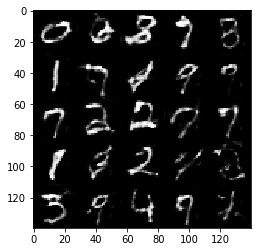

Epoch 2/2... Discriminator Loss: 1.9439... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.5344
Epoch 2/2... Discriminator Loss: 1.7150... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.8533... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 2.0593... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 2.5739... Generator Loss: 0.6123
Epoch 2/2... Discriminator Loss: 3.8159... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 2.2366... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.6177


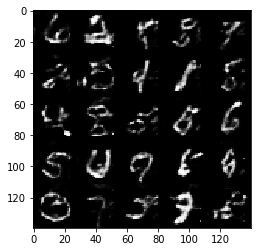

Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.6029... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 2.6422... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 2.2106... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 2.4517... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 1.5289... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 1.8940... Generator Loss: 4.1044


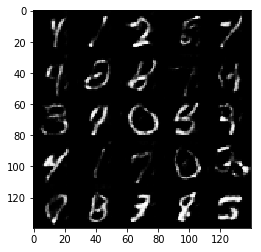

Epoch 2/2... Discriminator Loss: 1.8420... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 3.1013... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.9918... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 1.8164... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 2.3441... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 0.5422
Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.5672
Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 2.6236... Generator Loss: 0.6471


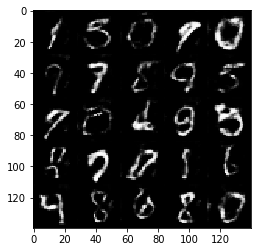

Epoch 2/2... Discriminator Loss: 1.9658... Generator Loss: 0.6596
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.9065... Generator Loss: 0.6282
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 2.3136... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 1.9029... Generator Loss: 0.6007
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.5523... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 3.2701... Generator Loss: 0.7081


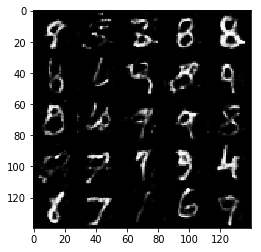

Epoch 2/2... Discriminator Loss: 1.6893... Generator Loss: 0.7369
Epoch 2/2... Discriminator Loss: 1.8547... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.6070... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.5152... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.7837... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 2.6182... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.6418... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 3.2776... Generator Loss: 3.1570


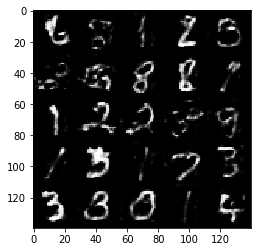

Epoch 2/2... Discriminator Loss: 1.5924... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 2.1165... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 1.7742... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.8967... Generator Loss: 2.3517
Epoch 2/2... Discriminator Loss: 1.5024... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 2.0759... Generator Loss: 0.6580


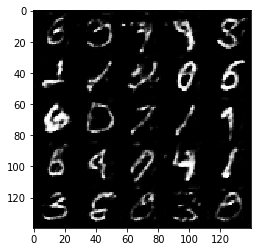

Epoch 2/2... Discriminator Loss: 1.5231... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.8221... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.9158... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 2.0402... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: -0.0823... Generator Loss: 1.5718
Epoch 2/2... Discriminator Loss: 2.6291... Generator Loss: 0.9866


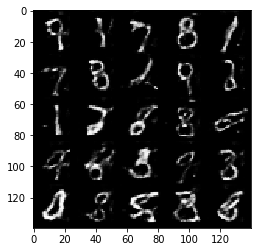

Epoch 2/2... Discriminator Loss: 2.3416... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 2.5649... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 2.8698... Generator Loss: 4.2578
Epoch 2/2... Discriminator Loss: 2.3900... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.5535... Generator Loss: 1.8109


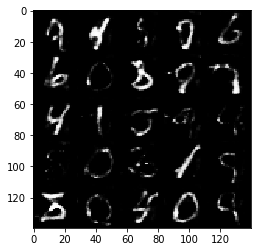

Epoch 2/2... Discriminator Loss: 0.2942... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: -0.0678... Generator Loss: 4.2491
Epoch 2/2... Discriminator Loss: 2.4649... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.7961... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.5280
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.8219


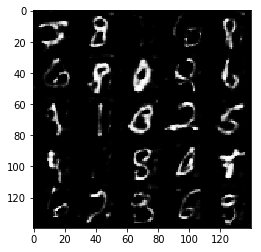

Epoch 2/2... Discriminator Loss: 1.5532... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 3.1205... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 2.0909... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.7086... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 0.5993
Epoch 2/2... Discriminator Loss: 0.2441... Generator Loss: 0.7187
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.2686
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 0.7248


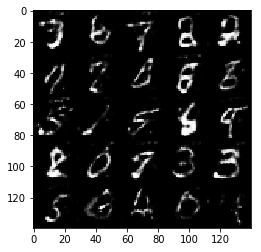

Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 3.3735
Epoch 2/2... Discriminator Loss: 0.4119... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.9660... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.7411


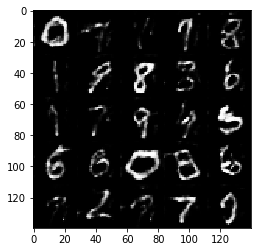

Epoch 2/2... Discriminator Loss: 1.8922... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 0.0276... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 0.4712... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 1.5633... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: -1.1173... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 0.6247... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.1107


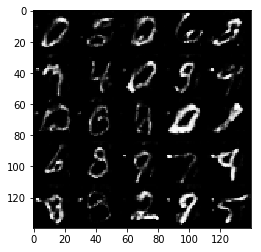

Epoch 2/2... Discriminator Loss: 0.4651... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 1.5956... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 2.7625
Epoch 2/2... Discriminator Loss: 0.4270... Generator Loss: 0.9055
Epoch 2/2... Discriminator Loss: -0.0326... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.1661
Epoch 2/2... Discriminator Loss: -0.2241... Generator Loss: 0.6753


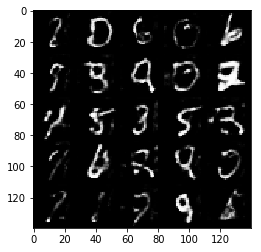

Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 0.3821... Generator Loss: 3.6665
Epoch 2/2... Discriminator Loss: 0.6377... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.6611
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.5650


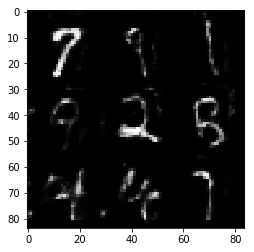

In [47]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3
alpha = 0.1

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

asda
Epoch 1/1... Discriminator Loss: 1.8328... Generator Loss: 1.9871
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 2.4083
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 3.3536
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.8509... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6538


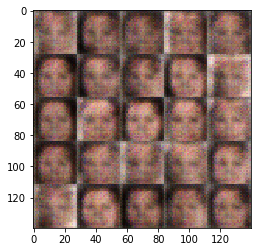

Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.8279... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.4530


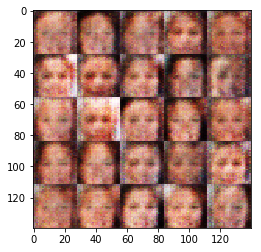

Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.5144


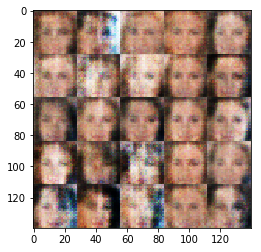

Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.5916... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.4834


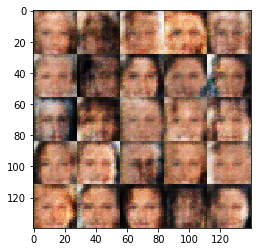

Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6036


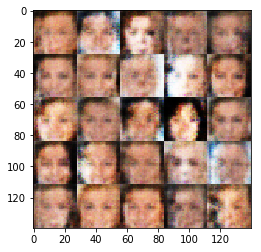

Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.5793


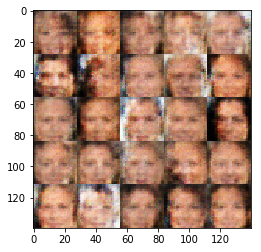

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.6270


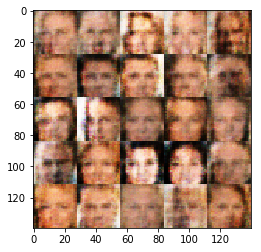

Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.7653


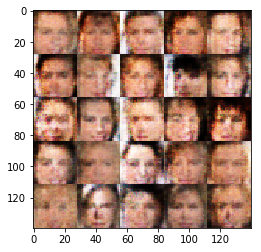

Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6346


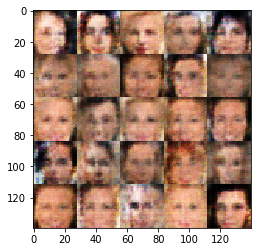

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6208


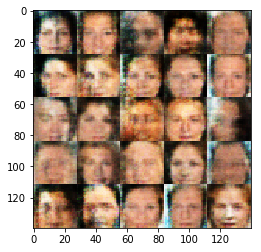

Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7730


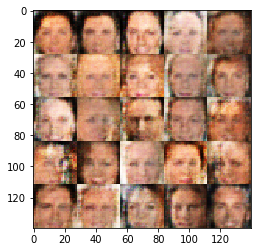

Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5657


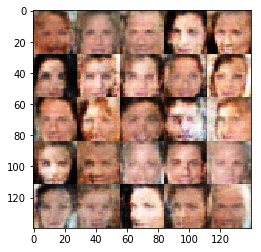

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.5642


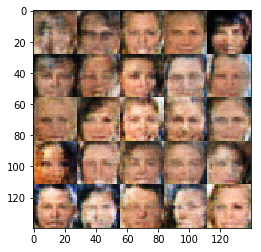

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.4907


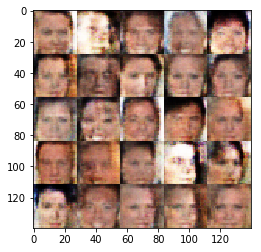

Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6695


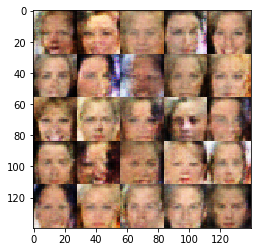

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7235


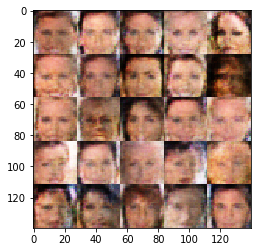

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6853


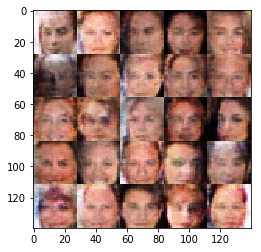

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7151


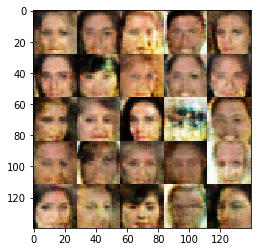

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7507


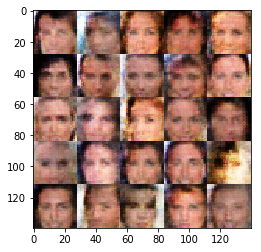

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6931


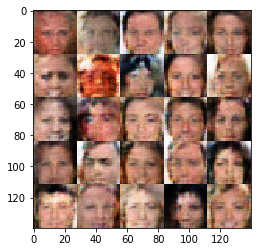

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.5819


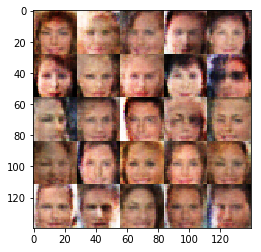

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7488


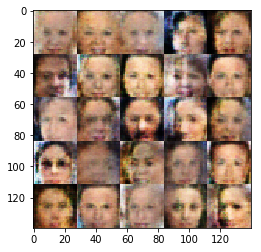

Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7541


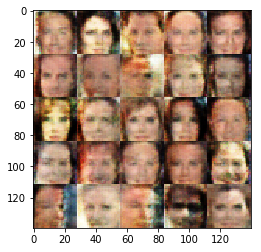

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6556


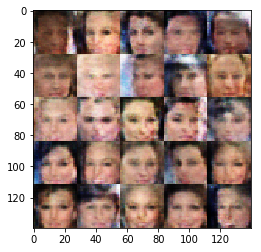

Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7254


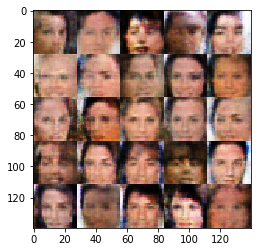

Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6830


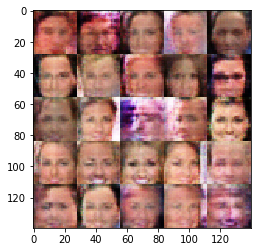

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5727


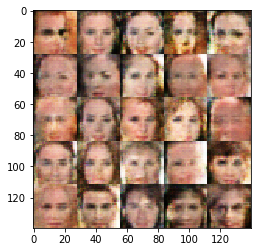

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6440


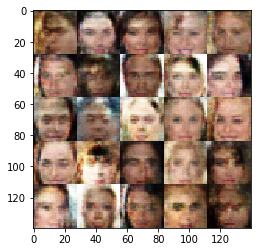

Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5994


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.